# A.2 : classification problem, logistic regression, impact of SBS / INDEL signatures
In this notebook, we compare, for the classification problem with the logistic regression, the following configurations :
- with only SBS mutational signatures
- with only INDEL mutational signatures
- with combination of both

## Table of contents

1. [Only SBS mutational signatures](#1-sbs)
2. [Only INDEL mutational signatures](#2-indel)
3. [SBS + INDEL mutational signatures](#3-comb)
4. [Evaluate performances](#4-performances)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.LogisticRegressionTrainTestManager import LogisticRegressionTrainTestManager

from sklearn.preprocessing import StandardScaler

from utils.featureSelection import featureSelection
from utils.preProcessing import preProcessing

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Set hyper-parameters

In [2]:
n_features = 5
n_epochs = 150
lr = 0.005
reg = 0.005

#### Reading and preprocessing

In [3]:
# Reading dataset
df = pd.read_excel('data/table-s1-sigmut-indel.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = preProcessing.relabel_patients(df,
                                    "Progression_1",
                                    "Time to progression (days)",
                                    t)

# Extract labels
y = df["Progression_1"].to_numpy()

### 1. Only SBS mutational signatures

#### Feature selection

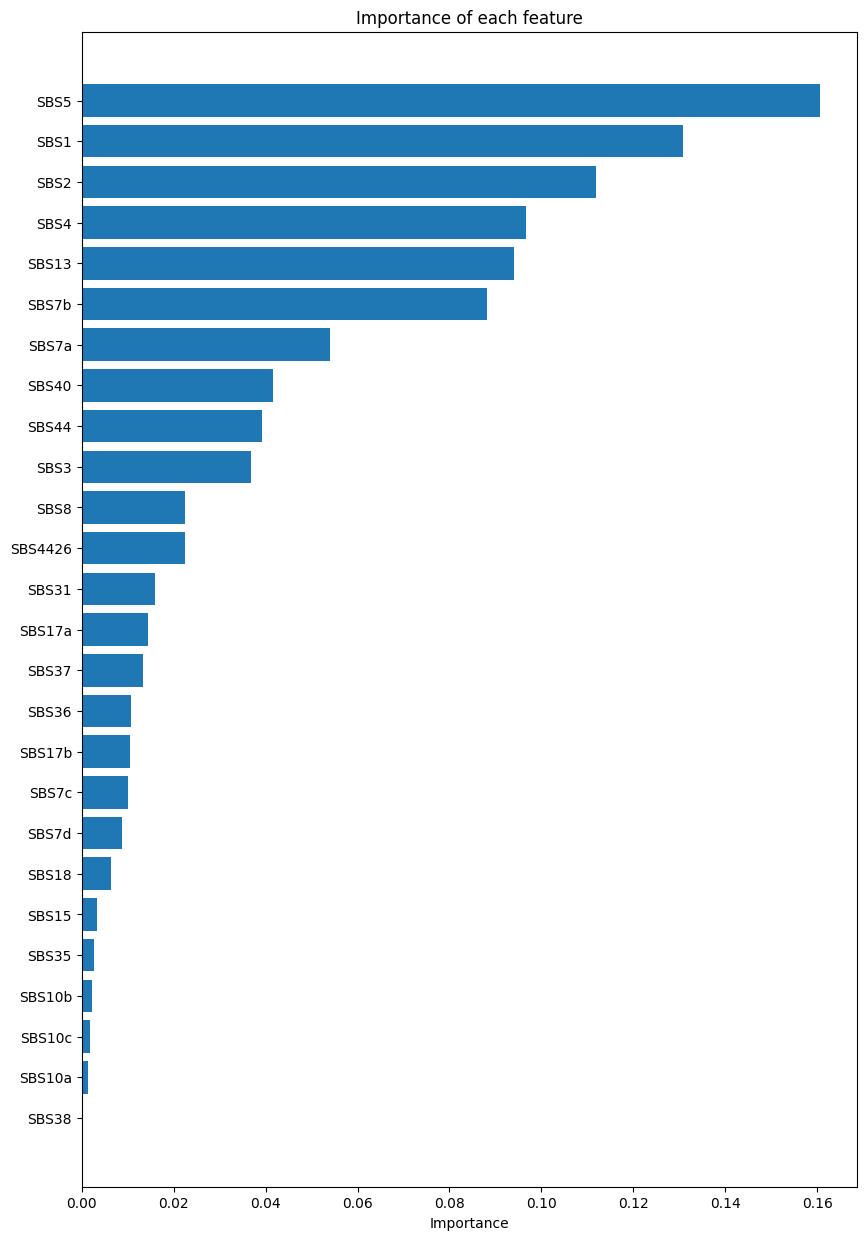

In [4]:
features_name_sbs = ["SBS1",
                        "SBS2",
                        "SBS3",
                        "SBS4",
                        "SBS5",
                        "SBS7a",
                        "SBS7b",
                        "SBS7c",
                        "SBS7d",
                        "SBS8",
                        "SBS10a",
                        "SBS10b",
                        "SBS10c",
                        "SBS13",
                        "SBS15",
                        "SBS17a",
                        "SBS17b",
                        "SBS18",
                        "SBS31",
                        "SBS35",
                        "SBS36",
                        "SBS37",
                        "SBS38",
                        "SBS40",
                        "SBS44",
                        "SBS4426"]

# Compute feature importance
features_name_sbs = featureSelection.feature_importance(df.loc[:, features_name_sbs],
                                                              y,
                                                              True)

# Select the most n_features important features
if n_features < len(features_name_sbs):
    features_name_sbs = features_name_sbs[:n_features]

# Extract features
X_sbs = df.loc[:, features_name_sbs].to_numpy()

#### Execute the leave one out CV

In [5]:
manager_sbs = LogisticRegressionTrainTestManager()
scores_sbs, classes_sbs, train_loss_sbs, val_loss_sbs = manager_sbs.leave_one_out_cv(X_sbs, y, n_epochs, lr, reg)

### 2. Only INDEL mutational signatures

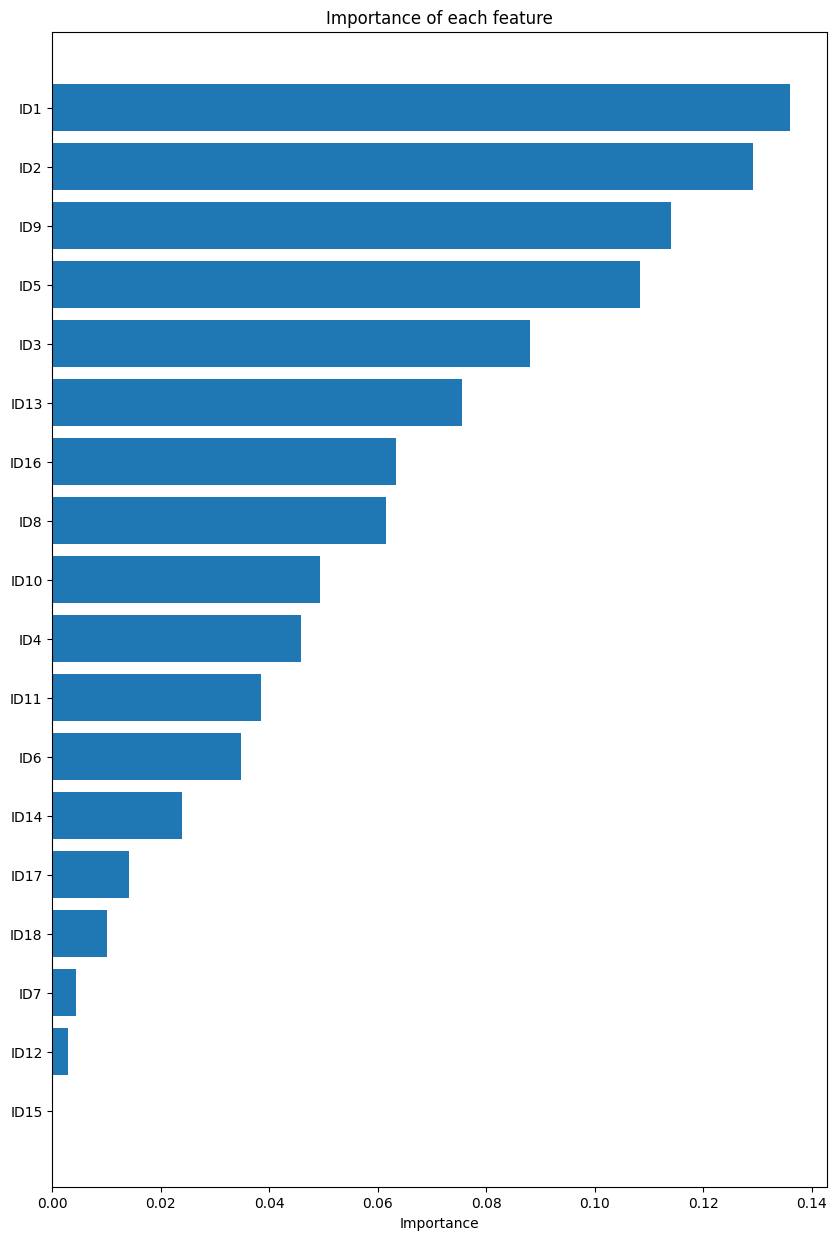

In [6]:
features_name_indel = ["ID1",
                        "ID2",
                        "ID3",
                        "ID4",
                        "ID5",
                        "ID6",
                        "ID7",
                        "ID8",
                        "ID9",
                        "ID10",
                        "ID11",
                        "ID12",
                        "ID13",
                        "ID14",
                        "ID15",
                        "ID16",
                        "ID17",
                        "ID18"]

# Compute feature importance
features_name_indel = featureSelection.feature_importance(df.loc[:, features_name_indel],
                                                              y,
                                                              True)

# Select the most n_features important features
if n_features < len(features_name_indel):
    features_name_indel = features_name_indel[:n_features]

# Extract features
X_indel = df.loc[:, features_name_indel].to_numpy()

In [7]:
manager_indel = LogisticRegressionTrainTestManager()
scores_indel, classes_indel, train_loss_indel, val_loss_indel = manager_indel.leave_one_out_cv(X_indel, y, n_epochs, lr, reg)

### 3. SBS + INDEL

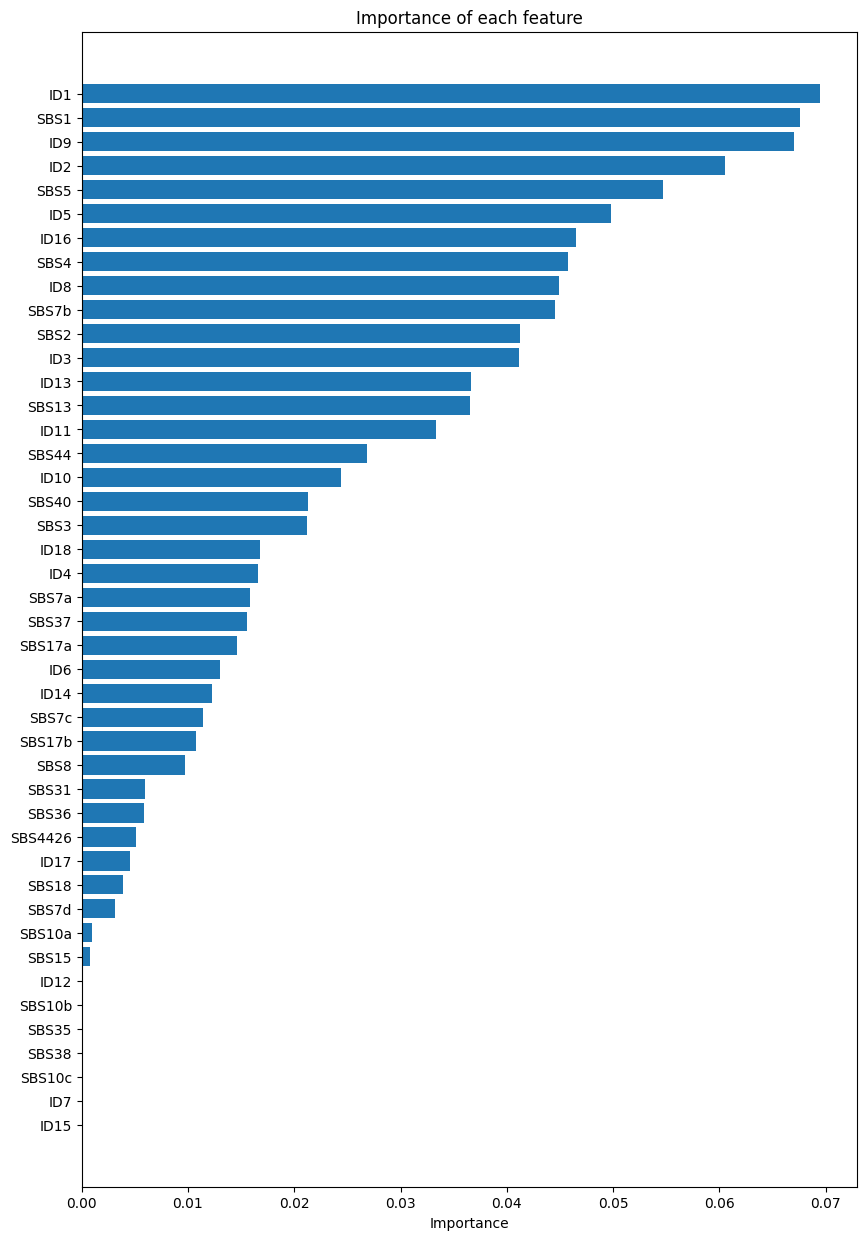

In [8]:
features_name_comb = ["SBS1",
                        "SBS2",
                        "SBS3",
                        "SBS4",
                        "SBS5",
                        "SBS7a",
                        "SBS7b",
                        "SBS7c",
                        "SBS7d",
                        "SBS8",
                        "SBS10a",
                        "SBS10b",
                        "SBS10c",
                        "SBS13",
                        "SBS15",
                        "SBS17a",
                        "SBS17b",
                        "SBS18",
                        "SBS31",
                        "SBS35",
                        "SBS36",
                        "SBS37",
                        "SBS38",
                        "SBS40",
                        "SBS44",
                        "SBS4426",
                        "ID1",
                        "ID2",
                        "ID3",
                        "ID4",
                        "ID5",
                        "ID6",
                        "ID7",
                        "ID8",
                        "ID9",
                        "ID10",
                        "ID11",
                        "ID12",
                        "ID13",
                        "ID14",
                        "ID15",
                        "ID16",
                        "ID17",
                        "ID18"]

# Compute feature importance
features_name_comb = featureSelection.feature_importance(df.loc[:, features_name_comb],
                                                              y,
                                                              True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb = features_name_comb[:n_features]

# Extract features
X_comb = df.loc[:, features_name_comb].to_numpy()

In [9]:
manager_comb = LogisticRegressionTrainTestManager()
scores_comb, classes_comb, train_loss_comb, val_loss_comb = manager_comb.leave_one_out_cv(X_comb, y, n_epochs, lr, reg)

### 4. Evaluate performances

#### Classification metrics

In [10]:
# No mutational signatures
fpr_sbs, tpr_sbs, thresholds_sbs = ClassificationMetrics.compute_roc_curve(y, scores_sbs)
sensitivity_sbs, specificity_sbs = ClassificationMetrics.compute_sensitivity_specificity(y,classes_sbs)
auc_sbs = ClassificationMetrics.compute_auc(y,scores_sbs)

# Only mutational signatures
fpr_indel, tpr_indel, thresholds_indel = ClassificationMetrics.compute_roc_curve(y, scores_indel)
sensitivity_indel, specificity_indel = ClassificationMetrics.compute_sensitivity_specificity(y,classes_indel)
auc_indel = ClassificationMetrics.compute_auc(y,scores_indel)

# Initial biomarkers + mutational signatures
fpr_comb, tpr_comb, thresholds_comb = ClassificationMetrics.compute_roc_curve(y, scores_comb)
sensitivity_comb, specificity_comb = ClassificationMetrics.compute_sensitivity_specificity(y,classes_comb)
auc_comb = ClassificationMetrics.compute_auc(y,scores_comb)

invalid value encountered in scalar divide
invalid value encountered in scalar divide
invalid value encountered in scalar divide


#### SHAP values

In [11]:
# No sigmut
X_torch_sbs = torch.from_numpy(X_sbs).float()
explainer_sbs = shap.DeepExplainer(manager_sbs.model,
                                X_torch_sbs)
shap_values_sbs = explainer_sbs.shap_values(X_torch_sbs)
expected_values_sbs = explainer_sbs.expected_value

# Only sigmut
X_torch_indel = torch.from_numpy(X_indel).float()
explainer_indel = shap.DeepExplainer(manager_indel.model,
                                X_torch_indel)
shap_values_indel = explainer_indel.shap_values(X_torch_indel)
expected_values_indel = explainer_indel.expected_value

# Initial biomarkers + mutational signatures
X_torch_comb = torch.from_numpy(X_comb).float()
explainer_comb = shap.DeepExplainer(manager_comb.model,
                                X_torch_comb)
shap_values_comb = explainer_comb.shap_values(X_torch_comb)
expected_values_comb = explainer_comb.expected_value

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


#### Plot results

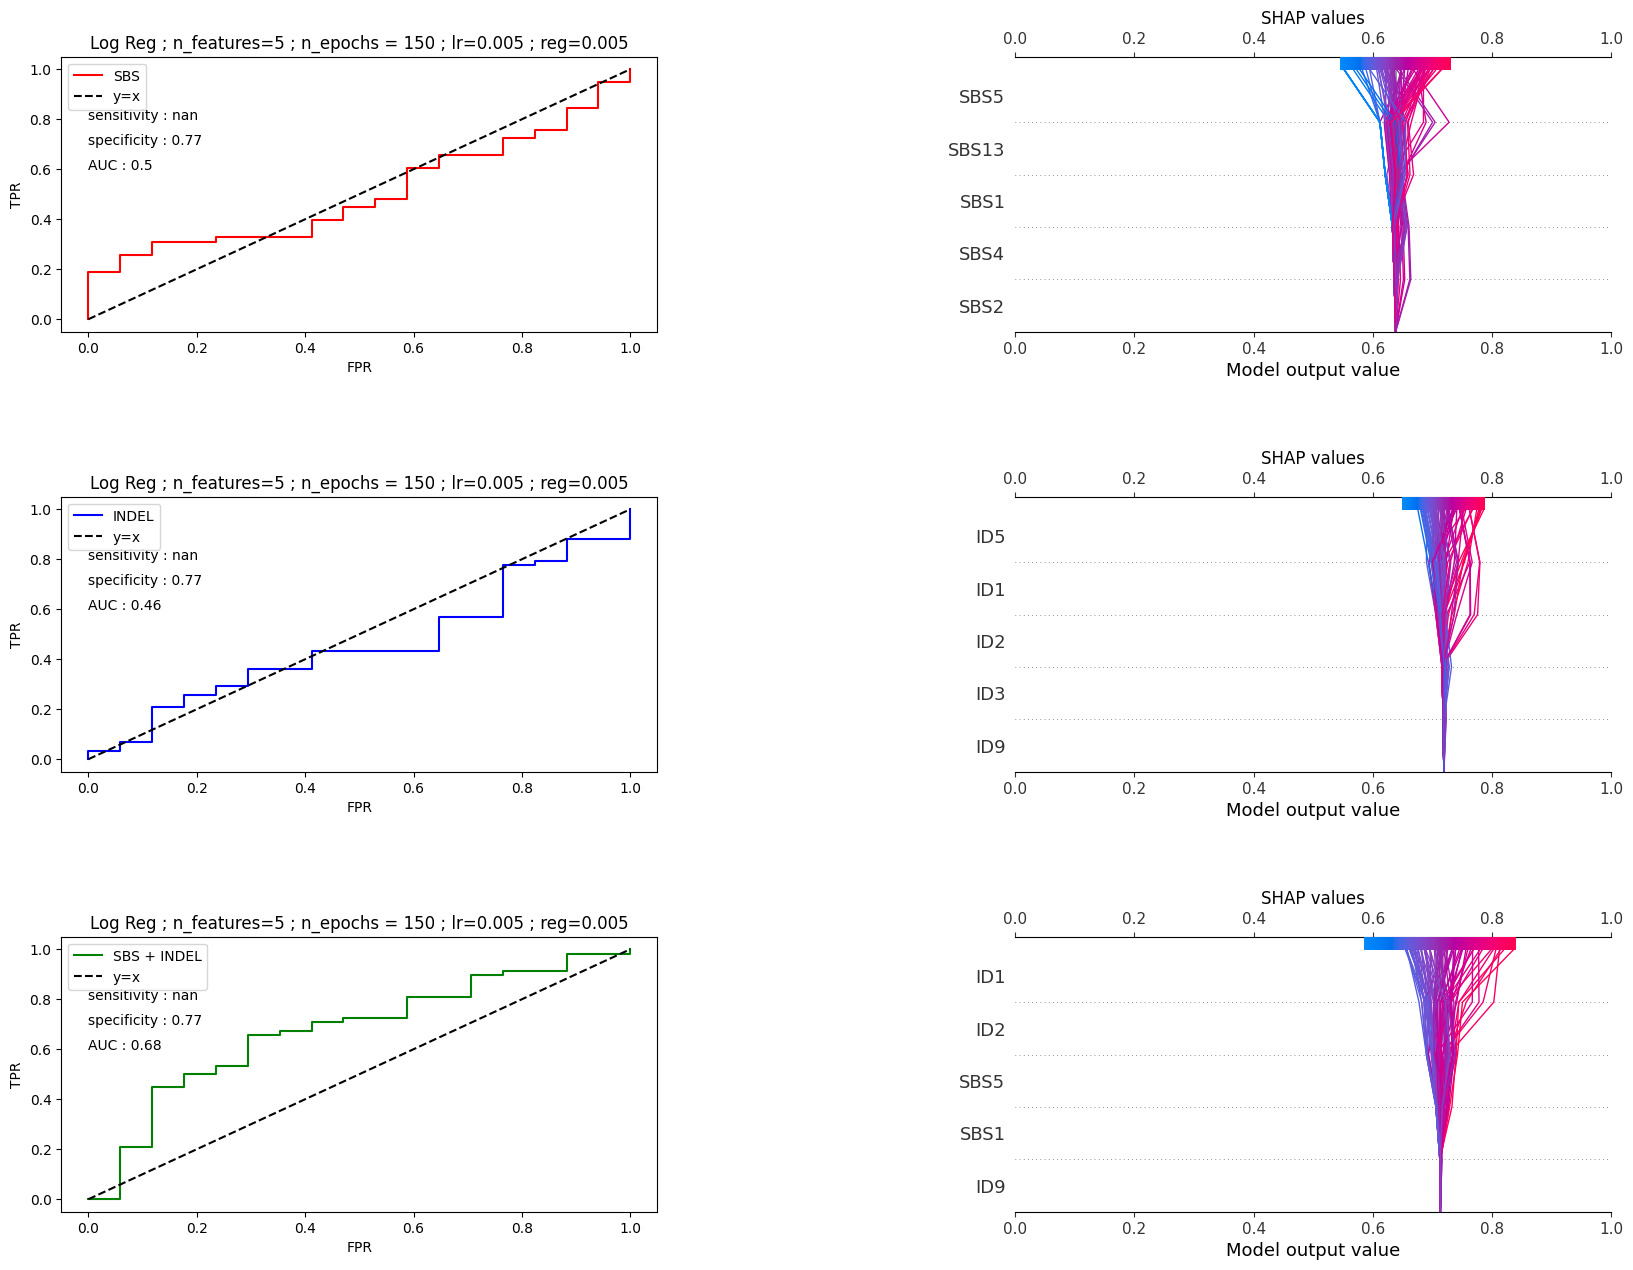

In [12]:
fig = plt.figure()
x = np.linspace(0,1,100)

# SBS
ax0 = fig.add_subplot(321)
ax0.plot(fpr_sbs, tpr_sbs, color='red',label='SBS')
ax0.plot(x,x,linestyle='--',color='black',label='y=x')
ax0.set_xlabel("FPR")
ax0.set_ylabel("TPR")
ax0.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax0.text(0,0.8,f"sensitivity : {sensitivity_sbs}")
ax0.text(0,0.7,f"specificity : {specificity_sbs}")
ax0.text(0,0.6,f"AUC : {auc_sbs}")
ax0.legend()

ax1 = fig.add_subplot(322)
shap.decision_plot(expected_values_sbs, shap_values_sbs, features_name_sbs, show=False)
ax1.set_title("SHAP values")
ax1.set_xlim(0,1)

# INDEL
ax2 = fig.add_subplot(323)
ax2.plot(fpr_indel, tpr_indel, color='blue',label='INDEL')
ax2.plot(x,x,linestyle='--',color='black',label='y=x')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
ax2.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax2.text(0,0.8,f"sensitivity : {sensitivity_indel}")
ax2.text(0,0.7,f"specificity : {specificity_indel}")
ax2.text(0,0.6,f"AUC : {auc_indel}")
ax2.legend()

ax3 = fig.add_subplot(324)
shap.decision_plot(expected_values_indel, shap_values_indel, features_name_indel, show=False)
ax3.set_title("SHAP values")
ax3.set_xlim(0,1)

# SBS + INDEL
ax4 = fig.add_subplot(325)
ax4.plot(fpr_comb, tpr_comb, color='green',label='SBS + INDEL')
ax4.plot(x,x,linestyle='--',color='black',label='y=x')
ax4.set_xlabel("FPR")
ax4.set_ylabel("TPR")
ax4.set_title(f"Log Reg ; n_features={n_features} ; n_epochs = {n_epochs} ; lr={lr} ; reg={reg}")
ax4.text(0,0.8,f"sensitivity : {sensitivity_comb}")
ax4.text(0,0.7,f"specificity : {specificity_comb}")
ax4.text(0,0.6,f"AUC : {auc_comb}")
ax4.legend()

ax5 = fig.add_subplot(326)
shap.decision_plot(expected_values_comb, shap_values_comb, features_name_comb, show=False)
ax5.set_title("SHAP values")
ax5.set_xlim(0,1)

plt.gcf().set_size_inches(20,15)
plt.subplots_adjust(hspace=0.6,wspace=0.6)
plt.show()

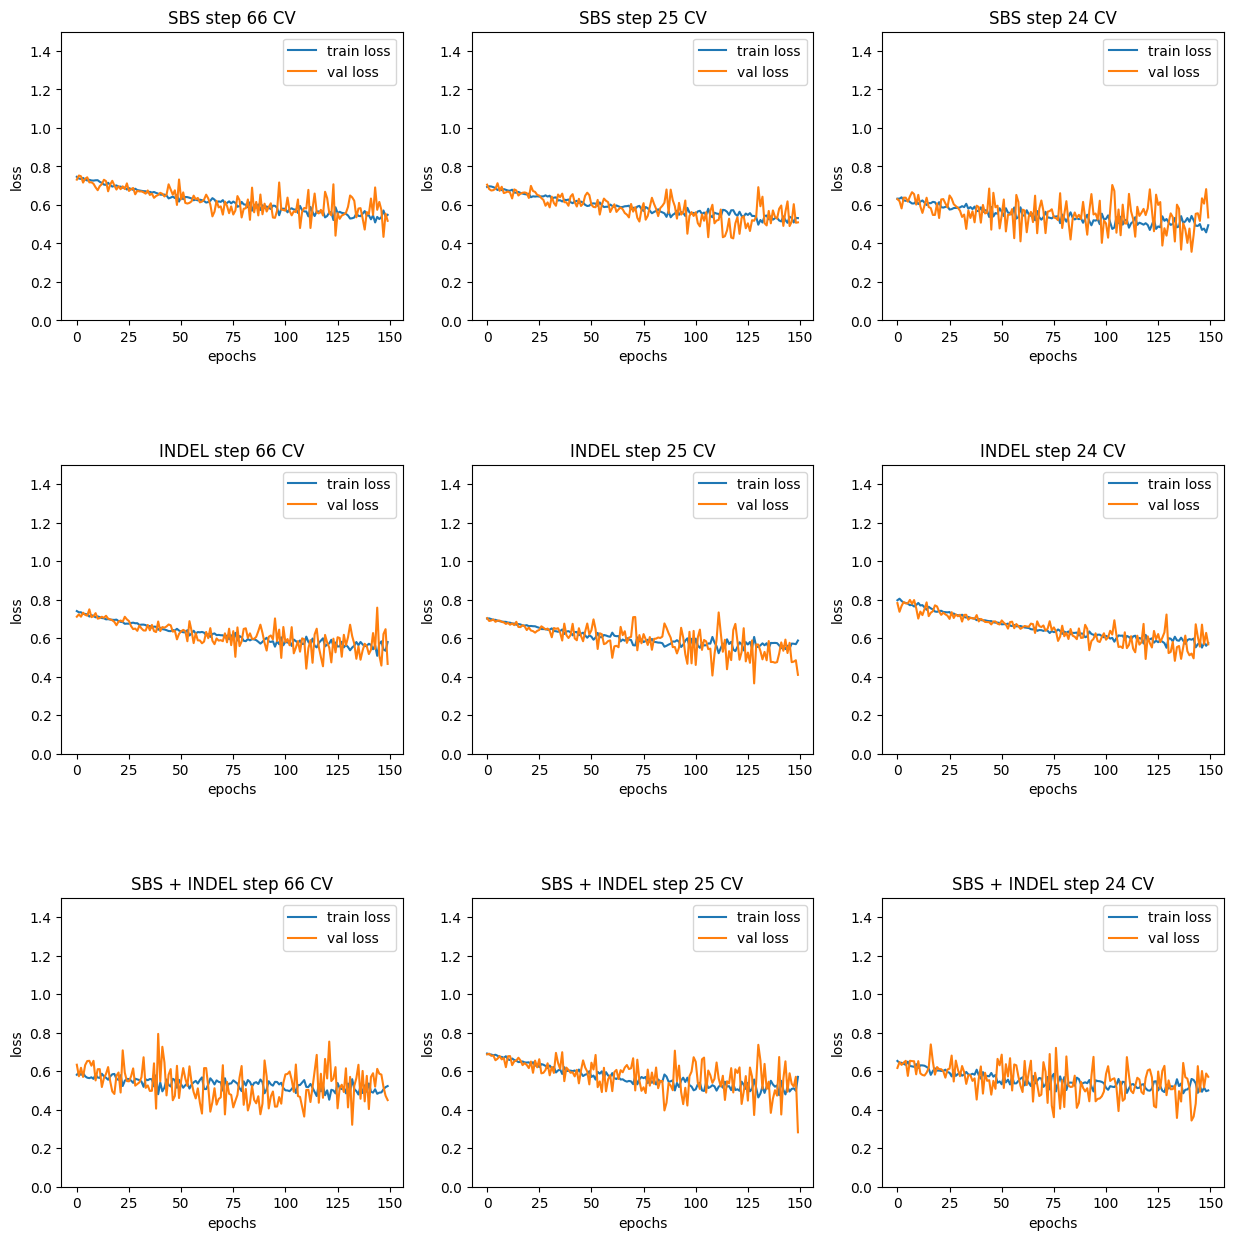

In [13]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(3,3,figsize=(15,15))

patient0 = np.random.randint(0,df.shape[0]-1)
patient1 = np.random.randint(0,df.shape[0]-1)
patient2 = np.random.randint(0,df.shape[0]-1)

# SBS :
ax[0,0].plot(epochs, train_loss_sbs[patient0],label='train loss')
ax[0,0].plot(epochs, val_loss_sbs[patient0],label='val loss')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title(f'SBS step {patient0} CV')
ax[0,0].set_ylim(0,1.5)
ax[0,0].legend()

ax[0,1].plot(epochs, train_loss_sbs[patient1],label='train loss')
ax[0,1].plot(epochs, val_loss_sbs[patient1],label='val loss')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title(f'SBS step {patient1} CV')
ax[0,1].set_ylim(0,1.5)
ax[0,1].legend()

ax[0,2].plot(epochs, train_loss_sbs[patient2],label='train loss')
ax[0,2].plot(epochs, val_loss_sbs[patient2],label='val loss')
ax[0,2].set_xlabel('epochs')
ax[0,2].set_ylabel('loss')
ax[0,2].set_title(f'SBS step {patient2} CV')
ax[0,2].set_ylim(0,1.5)
ax[0,2].legend()

# INDEL :
ax[1,0].plot(epochs, train_loss_indel[patient0],label='train loss')
ax[1,0].plot(epochs, val_loss_indel[patient0],label='val loss')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title(f'INDEL step {patient0} CV')
ax[1,0].set_ylim(0,1.5)
ax[1,0].legend()

ax[1,1].plot(epochs, train_loss_indel[patient1],label='train loss')
ax[1,1].plot(epochs, val_loss_indel[patient1],label='val loss')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('loss')
ax[1,1].set_title(f'INDEL step {patient1} CV')
ax[1,1].set_ylim(0,1.5)
ax[1,1].legend()

ax[1,2].plot(epochs, train_loss_indel[patient2],label='train loss')
ax[1,2].plot(epochs, val_loss_indel[patient2],label='val loss')
ax[1,2].set_xlabel('epochs')
ax[1,2].set_ylabel('loss')
ax[1,2].set_title(f'INDEL step {patient2} CV')
ax[1,2].set_ylim(0,1.5)
ax[1,2].legend()

# SBS + INDEL :
ax[2,0].plot(epochs, train_loss_comb[patient0],label='train loss')
ax[2,0].plot(epochs, val_loss_comb[patient0],label='val loss')
ax[2,0].set_xlabel('epochs')
ax[2,0].set_ylabel('loss')
ax[2,0].set_title(f'SBS + INDEL step {patient0} CV')
ax[2,0].set_ylim(0,1.5)
ax[2,0].legend()

ax[2,1].plot(epochs, train_loss_comb[patient1],label='train loss')
ax[2,1].plot(epochs, val_loss_comb[patient1],label='val loss')
ax[2,1].set_xlabel('epochs')
ax[2,1].set_ylabel('loss')
ax[2,1].set_title(f'SBS + INDEL step {patient1} CV')
ax[2,1].set_ylim(0,1.5)
ax[2,1].legend()

ax[2,2].plot(epochs, train_loss_comb[patient2],label='train loss')
ax[2,2].plot(epochs, val_loss_comb[patient2],label='val loss')
ax[2,2].set_xlabel('epochs')
ax[2,2].set_ylabel('loss')
ax[2,2].set_title(f'SBS + INDEL step {patient2} CV')
ax[2,2].set_ylim(0,1.5)
ax[2,2].legend()
plt.subplots_adjust(hspace=0.5)